In [1]:
# keep this here pls
!pip install xlrd 
#!pip install country_converter

In [96]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [95]:
#define path to xls
url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'
df = pd.read_excel(url)
df  # 6992 rows × 23 columns

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,...,Unknown,Todd Smith: Platform X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,...,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,...,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,...,Bronze whaler,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,...,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6.0,NaN,NaN
6990,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,...,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5.0,NaN,NaN
6991,1900-1905,0.0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,...,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4.0,NaN,NaN
6992,1883-1889,0.0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,...,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3.0,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6994 entries, 0 to 6993
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6994 non-null   object 
 1   Year            6992 non-null   float64
 2   Type            6976 non-null   object 
 3   Country         6944 non-null   object 
 4   State           6511 non-null   object 
 5   Location        6429 non-null   object 
 6   Activity        6409 non-null   object 
 7   Name            6775 non-null   object 
 8   Sex             6415 non-null   object 
 9   Age             4000 non-null   object 
 10  Injury          6959 non-null   object 
 11  Fatal Y/N       6433 non-null   object 
 12  Time            3468 non-null   object 
 13  Species         3862 non-null   object 
 14  Source          6975 non-null   object 
 15  pdf             6799 non-null   object 
 16  href formula    6794 non-null   object 
 17  href            6796 non-null   o

In [5]:
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,...,Unknown,Todd Smith: Platform X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,...,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,...,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,...,Bronze whaler,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.tail()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
6989,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,...,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6.0,NaN,NaN
6990,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,...,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5.0,NaN,NaN
6991,1900-1905,0.0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,...,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4.0,NaN,NaN
6992,1883-1889,0.0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,...,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3.0,NaN,NaN
6993,1845-1853,0.0,Unprovoked,CEYLON (SRI LANKA),Eastern Province,"Below the English fort, Trincomalee",Swimming,male,M,15,...,NaN,S.W. Baker,ND-0001-Ceylon.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0001,ND.0001,2.0,NaN,NaN


In [97]:
df.shape[0]
df.shape[1]

print("Number of Rows: ", df.shape[0])
print("Number of Columns: ", df.shape[1])

df.columns

# Issues w/ og file –> extra 8 columns on VSC? to preserve NaN
# Date, Year, Type, Country, State, Location, Activity, Name, Sex, Age, Injury, Fatal Y/N, Time, Specie, Source
# check search tool between uppercase and lowercase e.g. Australia / AUSTRALIA

Number of Rows:  6994
Number of Columns:  23


Index(['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity',
       'Name', 'Sex', 'Age', 'Injury', 'Fatal Y/N', 'Time', 'Species ',
       'Source', 'pdf', 'href formula', 'href', 'Case Number', 'Case Number.1',
       'original order', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

In [74]:
# df.columns

In [98]:
df.rename(columns= {
    'Fatal Y/N': 'Fatal',
    'Species ': 'Species',
    'pdf': 'PDF', 
    'Sex': 'Gender',
    'href formula': 'Href_formula', 
    'href': 'Href',
    'Case Number': 'Case_Number', 
    'Case Number.1': 'Case_Number_1',
    'original order': 'Original_Order', 
    'Unnamed: 21': 'Unnamed_21', 
    'Unnamed: 22': 'Unnamed_22'
}, inplace=True)
print(df.columns)

Index(['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity',
       'Name', 'Gender', 'Age', 'Injury', 'Fatal', 'Time', 'Species', 'Source',
       'PDF', 'Href_formula', 'Href', 'Case_Number', 'Case_Number_1',
       'Original_Order', 'Unnamed_21', 'Unnamed_22'],
      dtype='object')


In [99]:
df["Href_formula"].equals(df["Href"]) # Checking if its the same 

False

In [100]:
df["Href_formula"].isin(df["Href"]).value_counts() # There is less than 10% difference between the columns. I am keeping Href

Href_formula
True     6900
False      94
Name: count, dtype: int64

In [ ]:
# Dropping Columns
df = df.drop(columns=["Unnamed_21", "PDF" "Unnamed_22", "Href_formula", "Original_Order", "Case_Number","Case_Number_1"])
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,Injury,Fatal,Time,Species,Source,PDF,Href
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,Unknown,N,Unknown,Unknown,Todd Smith: Platform X,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,Bites to arm and upper body,Y,1645 hrs,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,Minor bite to lower body,N,1711hrs,Not stated,Bob Myatt GSAF,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,None - chunk of surfboard bitten out,N,1600hrs,Bronze whaler,Bob Myatt GSAF,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,Bitten on the arm,N,1340hrs,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN


In [103]:
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,Injury,Fatal,Time,Species,Source,PDF,Href
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,Unknown,N,Unknown,Unknown,Todd Smith: Platform X,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,Bites to arm and upper body,Y,1645 hrs,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,Minor bite to lower body,N,1711hrs,Not stated,Bob Myatt GSAF,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,None - chunk of surfboard bitten out,N,1600hrs,Bronze whaler,Bob Myatt GSAF,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,Bitten on the arm,N,1340hrs,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN


In [11]:
# Here I am trying to identify the number of unique values for each column and determine which columns appear to be categorical. 
unique_counts = df.nunique() # Identify the number of unique values for each column
print("\nUnique value counts per column: ")
print(unique_counts)


Unique value counts per column: 
Date              6042
Year               261
Type                12
Country            239
State              920
Location          4554
Activity          1598
Name              5728
Gender               8
Age                246
Injury            4122
Fatal               12
Time               436
Species           1706
Source            5347
PDF               6789
Href_formula      6784
Href              6776
Case_Number       6777
Case_Number_1     6775
Original_Order    6797
Unnamed_21           1
Unnamed_22           2
dtype: int64


In [ ]:
#Checking for null values in each column 
df.isna().any()

Date              False
Year               True
Type               True
Country            True
State              True
Location           True
Activity           True
Name               True
Gender             True
Age                True
Injury             True
Fatal              True
Time               True
Species            True
Source             True
PDF                True
Href_formula       True
Href               True
Case_Number        True
Case_Number_1      True
Original_Order     True
Unnamed_21         True
Unnamed_22         True
dtype: bool

In [13]:
df.isna().sum()

Date                 0
Year                 2
Type                18
Country             50
State              483
Location           565
Activity           585
Name               219
Gender             579
Age               2994
Injury              35
Fatal              561
Time              3526
Species           3132
Source              19
PDF                195
Href_formula       200
Href               198
Case_Number        196
Case_Number_1      197
Original_Order     195
Unnamed_21        6993
Unnamed_22        6992
dtype: int64

In [14]:
df.duplicated().sum()

0

In [15]:
df.duplicated().any()

False

In [16]:
df.describe()

,Year,Original_Order
count,6992.000000,6799.000000
mean,1935.044336,3401.152081
std,272.048128,1963.076319
min,0.000000,2.000000
25%,1947.000000,1701.500000
50%,1986.000000,3401.000000
75%,2009.000000,5100.500000
max,2026.000000,6802.000000


In [17]:
#Count the number of null values in each column
df.isna().sum()

Date                 0
Year                 2
Type                18
Country             50
State              483
Location           565
Activity           585
Name               219
Gender             579
Age               2994
Injury              35
Fatal              561
Time              3526
Species           3132
Source              19
PDF                195
Href_formula       200
Href               198
Case_Number        196
Case_Number_1      197
Original_Order     195
Unnamed_21        6993
Unnamed_22        6992
dtype: int64

In [18]:
df.Type.unique()

array(['Unprovoked', 'Provoked', ' Provoked', 'Questionable',
       'Watercraft', 'Sea Disaster', nan, '?', 'Unconfirmed',
       'Unverified', 'Invalid', 'Under investigation', 'Boat'],
      dtype=object)

In [19]:
print(df["Type"].value_counts()) 

Type
Unprovoked             5155
Provoked                637
Invalid                 552
Watercraft              355
Sea Disaster            242
Questionable             22
Boat                      7
 Provoked                 2
?                         1
Unconfirmed               1
Unverified                1
Under investigation       1
Name: count, dtype: int64


In [20]:
print(df["Type"].value_counts(dropna=False)) # I wanted to review the Nan 

Type
Unprovoked             5155
Provoked                637
Invalid                 552
Watercraft              355
Sea Disaster            242
Questionable             22
NaN                      18
Boat                      7
 Provoked                 2
?                         1
Unconfirmed               1
Unverified                1
Under investigation       1
Name: count, dtype: int64


In [21]:
#df_nan = df[df["Type"].isna()]
#df_nan

#3df["Type"] = df["Type"].isnull().sum

In [22]:
# Data Cleaning for the Column 'Type' 

#Reviewing how many were provoked and unprovoked 
print(df["Type"].unique())
# What is the meaning in here as "Provoked"?? 

['Unprovoked' 'Provoked' ' Provoked' 'Questionable' 'Watercraft'
 'Sea Disaster' nan '?' 'Unconfirmed' 'Unverified' 'Invalid'
 'Under investigation' 'Boat']


In [23]:
df["Type"] = df["Type"].str.strip()
df["Type"] = df["Type"].replace({
    " Provoked": "Provoked", 
    "Unconfirmed": "Unknown",
    "?" : "Unknown",
    "Invalid": "Unknown",
    "Under investigation": "Unknown",
    "Questionable": "Unknown", 
    "Watercraft" : "Water Vehicle", 
    "Boat" : "Water Vehicle"

})

df["Type"] = df["Type"].fillna("Unknown")
print(df["Type"].unique())

['Unprovoked' 'Provoked' 'Unknown' 'Water Vehicle' 'Sea Disaster'
 'Unverified']


In [24]:
# Data Cleaning for the Column Gender

df["Gender"] = df["Gender"].replace({
    " M": "M", 
    "M ": "M", 
    "M x 2": "M", 
    " nan": "Unknown", 
    "lli": "Unknown", 
    "N": "M", 
    ".": "Unknown"
    })
df["Gender"] = df["Gender"].fillna("Unknown")
df.Gender.unique()

array(['F', 'M', 'Unknown'], dtype=object)

In [25]:
df["Species"].unique()
print(df["Species"].unique()[:600])

['Unknown' 'Bull shark' 'Not stated' 'Bronze whaler'
 'Reportedly Tiger or Bull shark' 'Great White Shart estimated 4.8m 16 ft'
 'Reportedly a Tiger Shark' 'Unknown ' '1m shark species unknown'
 'Great White Shark' 'Reported as a large Tiger shark'
 'Bull or tiger 7-8ft' 'Bull shark 6ft' 'Bull shark 6-7ft'
 'Reportedly a Great White' 'Reportedly Tiger Shark'
 'Reef shark 6ft (1.8m)' '3m White Shark' 'Undetermined small shall shark'
 '4-5ft Blacktip shark' 'Not specified' 'Bull shark 6 ft' '6 ft shark'
 '6ft shark' 'Not stated area has Tiger and Galapogas sharks'
 'Not specified Bull shark highly suspect' 'Large shark' '2.5m shark'
 '3m Sandbar shark' 'Bull shark 3m ' 'Carribean reef shark 7ft'
 'Great White' 'Tiger shark' "Tiger shark 8'" "3' to 4' shark"
 "Bull shark, 7'" 'Blacktip reef shark' nan 'White shark'
 'Raggedtooth shark' "White shark, 13'" 'Broze whaler?' 'Sevengill shark'
 'Shark involment not confirmed' '1.8m bull shark' 'Lemon shark'
 'Oceanic whitetip shark' 'White Shar

In [26]:
# Cleaning the Column 'Species' a bit 
df["Species"] = df["Species"].str.extract(r'([A-Za-z\s-]+)').fillna("Unknown") # Cleaning here the unnecessary details
df["Species"] = df["Species"].replace({
    "Not stated":"Unknown"
})
print(df["Species"])

0             Unknown
1          Bull shark
2             Unknown
3       Bronze whaler
4             Unknown
            ...      
6989          Unknown
6990          Unknown
6991          Unknown
6992          Unknown
6993          Unknown
Name: Species, Length: 6994, dtype: object


In [27]:
df["Species_Types"] = df["Species"].copy() # creating a copy of species and naming it Species_Types

In [28]:
df["Species_Types"] = df["Species_Types"].fillna("Unknown").astype(str)

In [29]:
df["Species_Types"] = df["Species_Types"].replace({
    "Not stated": "Unknown",
    "Not specified": "Unknown",
    "Invalid": "Unknown",
    "Great White Shark": "White Shark"   
}) 

In [30]:
#Data Cleanining for the Column 'Species'
#df["Species"].unique() df["Species"] = df["Species"]
#df["Species"]
#df.Species.unique()

def clean_shark_name(species): 
    species = species.strip().lower()

    match = re.search(r"(?:\b\w+\s+)*?(great white|horn|white|tiger|bull|Bull|hammerhead|hammer|Hammerhead|blacktip|whale|nurse|mako|reef|Reef)(?:\s+\w+)*?\s*shark(?:\s+\w+)*?", species)
    #match = re.search(r"(great white|white|tiger|bull|hammerhead|blacktip|whale|nurse|mako|reef)s*shark", species)

    if match:
        #return match.group(0).title()
        return match.group(1).title() + " Shark"
    else: 
        return "Other/Unknown"

df["Species_Types"] = df["Species_Types"].apply(clean_shark_name)

print(df["Species_Types"].value_counts())  # Check unique values
print(df["Species_Types"].tail())  # Display first few rows
#print(df_Species.nunique()) 
#print(df_Species.unique()[:100])

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: count, dtype: int64
6989    Other/Unknown
6990    Other/Unknown
6991    Other/Unknown
6992    Other/Unknown
6993    Other/Unknown
Name: Species_Types, dtype: object


In [31]:
#df.dtypes
df["Species_Types"].value_counts()

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: count, dtype: int64

In [32]:
df["Species_Types"] = df["Species_Types"].str.strip()

In [33]:
print(df["Species_Types"].value_counts())

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: count, dtype: int64


In [34]:

# This can be ignored, but can be usable for in the future
#Group_Species = df.groupby("Species")

#for species, group in Group_Species:
#    print(f"Group name: {species}")
#   # display(group)
#df["Species"].nunique() == len(Grouped_Species)

In [ ]:
#df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [ ]:
# Data Cleaning for the column 'Country', I've tried to use regex 
df["Country"] = df["Country"].str.strip().str.title()
df["Country"] = df["Country"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
#df["Country"] = df["Country"].map(lambda x: x.upper())
df["Country"] = df["Country"].fillna("Unknown")
print(df["Country"].unique())

In [109]:
# Cleaning for location
df["Location"] = df["Location"].astype(str)
df["Location"] = df["Location"].map(lambda x:x.upper())
df["Location"] = df["Location"].fillna("Unknown")
df["Location"] = df["Location"].str.strip()
df["Location"] = df["Location"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown", 
})
df["Location"] 

0                       THOMPSON COVE BEACH
1              WOORIM BEACH, BRIBIE ISLAND,
2                            SHIPWRECK COVE
3                             CHEYNES BEACH
4             OFF HALEIWA BOAT HARBOUR OAHU
                       ...                 
6989                            ROEBUCK BAY
6990                                UNKNOWN
6991                         OCRACOKE INLET
6992                   PANAMA BAY 8ºN, 79ºW
6993    BELOW THE ENGLISH FORT, TRINCOMALEE
Name: Location, Length: 6994, dtype: object

In [110]:
# Data Cleaning for the Column 'State'
#df["State"] = df["State"].
df["State"] = df["State"].fillna("Unknown")
df["State"] = df["State"].astype(str)
df["State"] = df["State"].str.strip()
df["State"] = df["State"].replace({
    "NAN": "Unknown",
    "nan": "Unknown",
    "Nan": "Unknown", 
    " ": "Unknown",
    "  ": "Unknown"
})
print(df["State"].unique())

['Unknown' 'Queensland' 'Western Australia' 'Hawaii' 'Grande Terre'
 'South Australia' 'North of Marsa Alam' 'Phang Nga Province'
 'Bay of Waitangi' 'Kaafu' 'Maui' 'Florida' 'Tela' 'Trujillo Colon'
 'Southern Morocco' 'Montego Bay' 'Gulf of Honduras' 'NSW' 'Texas'
 'Floria' 'California' 'Maahvah Laamu Atoll' 'Galveston'
 'Providenciales Island' 'Gambier Islands' 'South Carolina'
 'Graet Courland Bay' 'Clarence Town Long Isand' 'Nunu Atoll'
 'Maharashtra' 'New  South Wales' 'Paradise Island'
 'Eastern Cape Province' 'Sonora' 'New South Wales' 'South Island'
 'Guerrero' 'New Providence   Isoad' 'Jalisco' 'Grand  Bahama Island'
 'Westerm Australia' 'North Island' 'Southern Red Sea' 'Quintana Roo'
 'Belize District' 'South Sinai' 'Bolinao' 'North Carolina' 'Valencia'
 'Norte' "Savai'i island" 'New York' 'San Andrés Island'
 'Galapagos Islands' 'Red Sea Protectorate' 'Freeport' 'Tahiti' 'Poum'
 'Lucayan Lucayan Archipelago' 'Utah' 'New Jersey' 'Mayabeque'
 'Easten Cape Province' 'Artemisa' 

In [111]:
# Data Cleaning for the Column Activity 
df["Activity"] = df["Activity"].fillna("Unknown")
df["Activity"] = df["Activity"].astype(str)
df["Activity"] = df["Activity"].str.strip()
df["Activity"] = df["Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown",
})
# Needs more cleaning 

In [112]:
df.isna().sum()

Date           0
Year           2
Type          18
Country       50
State          0
Location       0
Activity       0
Name         219
Gender       579
Age         2994
Injury        35
Fatal        561
Time        3526
Species     3132
Source        19
PDF          195
Href         198
dtype: int64

In [ ]:
# Data Cleaning for the Column 'Name' 
df["Activity"] = df["Activity"].fillna("Unknown")
df["Activity"] = df["Activity"].astype(str)
df["Activity"] = df["Activity"].str.strip()
df["Activity"] = df["Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown",
})
# Needs to be furthered cleaned 

In [ ]:
# Data Cleaning for the Column Age
# df["Age"] = df["Age"].astype()
# df["Age"] = df["Age"]
# df["Age"] = df["Age"]


In [ ]:
# Data Cleaning for The Column Fatal
df["Fatal"] = df["Fatal"].fillna("Unknown")
df["Fatal"] = df["Fatal"].astype(str)
df["Fatal"] = df["Fatal"].replace({
    "Nan": "Unknown",
    " N": "N",
    "UNKNOWN": "Unknown",
    "F": "Unknown",\
    "M": "N",
    "n": "N",
    "Nq": "N",
     2017: "Unknown",
     "Y x 2": "Y",
     "y": "Y",
     "N   ": "N",
})
#df["Fatal"] = df["Fatal"]
#df["Fatal"] = df["Fatal"]
#df["Fatal"] = df["Fatal"]

In [ ]:
df['Fatal'].value_counts(dropna=False)

In [38]:
df_count = df.groupby("Year")["Date"].count()
df_count

Year
0.0       129
5.0         1
77.0        1
1000.0      1
1500.0      1
         ... 
2022.0     98
2023.0    109
2024.0     49
2025.0      8
2026.0      1
Name: Date, Length: 261, dtype: int64

In [39]:
df["Date"].value_counts()

Date
1957           9
1942           8
1958           7
No date        6
1941           6
              ..
19-Sep-2000    1
24-Sep-2000    1
25-Sep-2000    1
29-Sep-2000    1
1845-1853      1
Name: count, Length: 6042, dtype: int64

<Axes: xlabel='Year'>

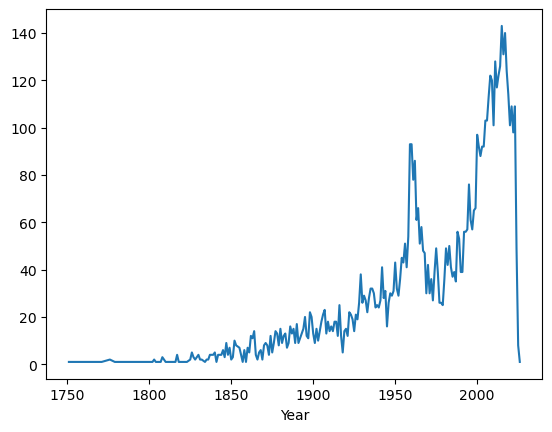

In [37]:
df_count = df.groupby("Year")["Date"].count()
df_count[df_count.index > 1750].plot()

In [40]:
df_count#.isna().sum()

Year
0.0       129
5.0         1
77.0        1
1000.0      1
1500.0      1
         ... 
2022.0     98
2023.0    109
2024.0     49
2025.0      8
2026.0      1
Name: Date, Length: 261, dtype: int64

In [43]:
df["Country"].value_counts()

Country
USA                   2556
AUSTRALIA             1481
SOUTH AFRICA           597
NEW ZEALAND            144
PAPUA NEW GUINEA       136
                      ... 
EGYPT / ISRAEL           1
Seychelles               1
GRAND CAYMAN             1
ST. MAARTIN              1
CEYLON (SRI LANKA)       1
Name: count, Length: 239, dtype: int64

In [44]:
df_usa = df[df["Country"] == "USA"]
df_usa

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,...,Source,PDF,Href_formula,Href,Case_Number,Case_Number_1,Original_Order,Unnamed_21,Unnamed_22,Species_Types
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
17,2024-10-25 00:00:00,2024.0,Unprovoked,USA,Florida,"Bathtub Beach, Martin County",Surfing,Cole Taschman,M,27,...,Bob Myatt: Yardbarker: 12 on your side: WPTV: ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
19,2024-10-11 00:00:00,2024.0,Unprovoked,USA,Florida,Brevard County Orlando,Surfing,Teddy Witteman,M,16,...,Todd SmithFlorida today: News 4:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bull Shark
26,2024-07-08 00:00:00,2024.0,Unprovoked,USA,Florida,Ponce de Leon Inlet Volusia County,Diving into Water,Dempsey Manhart,M,14,...,Miami Herald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
27,2024-07-05 00:00:00,2024.0,Unprovoked,USA,Florida,New Smyrna Beach,Wading,Not stated,M,26,...,Sacbee Fox 35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6941,Before 1958,0.0,Unprovoked,USA,Florida,"Palm Beach, Palm Beach County",Standing,Horton Chase,M,NaN,...,"V.M. Coppleson (1956), p.255; R.F. Hutton",ND-0056-HortonChase.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0056,ND.0056,54.0,NaN,NaN,Other/Unknown
6975,Before 1921,0.0,Unprovoked,USA,Florida,"Gadsden Point, Tampa Bay",Fishing,James Kelley,M,NaN,...,"T. Helm, p.219",ND-0019-Kelley.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0019,ND.0019,20.0,NaN,NaN,Other/Unknown
6980,Before 17-Jul-1916,0.0,Unprovoked,USA,North Carolina,Somewhere between Hatteras and Beaufort,Swimming,"""youthful male""",M,NaN,...,"C. Creswell, GSAF; Wilmington Star, 7/17/1916",ND-0014-pre1916-NorthCarolina.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0014,ND.0014,15.0,NaN,NaN,Other/Unknown
6984,Circa 1862,0.0,Unprovoked,USA,Hawaii,Puna,NaN,"A ""chiefess""",F,NaN,...,Captain W. Young,ND-0010-Puna Hawaii.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0010,ND.0010,11.0,NaN,NaN,Other/Unknown


In [117]:
#df_count = df.groupby("Country")["Year"].count()
#df_count[df_count.index > 1750].plot()

In [106]:
#df["Date"] = pd.to_datetime(df["Date"]) # Converting Object to dfate 
set(df["Date"].sample(n=50))

{'01-Jul-1958',
 '01-Oct-1999',
 '02-Feb-1957',
 '03-Jan-1989',
 '03-Jan-1999',
 '03-Sep-1981',
 '04-Aug-1960',
 '04-Aug-1997',
 '04-Aug-2012',
 '04-Feb-2023',
 '05-Dec-2010',
 '05-Oct-2011',
 '08-Jul-1926',
 '10-Feb-1975',
 '10-Jul-2022',
 '11-Jun-2008',
 '13-Apr-2006',
 '13-Sep-1900',
 '14-Jul-1997',
 '15-Jun-1941',
 '17-Jun-1886',
 '18-Aug-1884',
 '18-Sep-1992',
 '1883-1889',
 '20-Jul-2003',
 '20-Jul-2022',
 '21-Apr-2019',
 '21-Jan-1988',
 '21-Jan-2021',
 '22-Aug-1995',
 '22-Oct-1951',
 '24-Aug-2018',
 '24-Jun-1892',
 '24-May-1995',
 '24-Nov-1872',
 '24-Nov-1980',
 '25-Aug-1973',
 '26-Jun-2012',
 '27-Jan-2012',
 '27-Mar-2004',
 'Before 2011',
 'Ca. 1911',
 'Dec-1977',
 'Jun-1965',
 'Mar-1959',
 'Reported 02-Dec-1926',
 'Reported 04-Aug-1936',
 'Reported 09-May 1927',
 'Reported 12-Jan-1950',
 'Reported 24-Jan-1920'}

In [ ]:
len(set(df["Date"])) # Too Many Values To go One by One.

6042

In [ ]:
#df_usa["Date"].value_counts()

In [ ]:
#pd.to_datetime(df_usa["Data_Clean"])